# Synthetic data

In [25]:
import timeit
import warnings

import numpy as np
import shap
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

from windowshap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP

warnings.filterwarnings('ignore')

%matplotlib inline
shap.initjs()

This function generates a synthetic time series in which each feature sequence is generated using the sin() or cos() function. However, an anomaly interval is inserted at random into one of the feature sequences. If the feature with the anomaly is the first feature, the sample label is 1; otherwise, it is 0.

In [26]:
def synthetic_data(n_samples=100, n_steps=10, n_features=4):
    # Creating input data
    lam = 0.2
    anomaly_lam = 10
    eps = np.random.normal
    x = np.zeros((n_samples, n_steps, n_features))
    labels = np.zeros(n_samples)
    for i in range(n_samples):
        t0 = np.random.randint(1, 5, size=n_features)
        w = np.random.randint(1, 5, size=n_features)
        t = np.arange(n_steps)
        for j in range(n_features):
            if j % 2 == 0:
                x[i, :, j] = np.sin((t - t0[j]) / w[j])
            else:
                x[i, :, j] = np.cos((t - t0[j]) / w[j])
            x[i, :, j] = x[i, :, j] + lam * eps(size=n_steps)

        # adding anomaly
        #         anom_dur = np.random.randint(n_steps/10, n_steps/2)
        anom_dur = 20
        anom_start = np.random.randint(0, n_steps - anom_dur)
        anom_end = anom_start + anom_dur

        anom_j = np.random.randint(0, n_features)
        x[i, anom_start:anom_end, anom_j] += anomaly_lam * eps(size=anom_dur)

        # Creating the label
        labels[i] = 1 if anom_j == 0 else 0
    return x, labels

Data seperation to test and train

In [27]:
x, label = synthetic_data(n_samples=10000, n_steps=120, n_features=4)
train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=0.3, random_state=0,
                                                    stratify=label)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0,
                                                  stratify=train_y)

# Prediction Model

In [32]:
from tensorflow.python.keras.layers import Dense, Dropout, GRU
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

num_hidden = [70, 20]
num_neurons = 200
es_patience = 20
epochs = 40
num_output = 1
batch_size = 32
drop_rate = 0.3
reg_rate = 0.004

K.clear_session()
model = Sequential()
input_shape = (x.shape[1], x.shape[2])
model.add(GRU(units=num_neurons, activation='relu', input_shape=input_shape,
              recurrent_dropout=0.1, dropout=0.1))
for i in num_hidden:
    model.add(Dropout(drop_rate))
    model.add(Dense(units=i, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(units=num_output, activation='sigmoid'))

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Class weights
class_weights = {0: len(train_y) / (train_y == 0).sum(),
                 1: len(train_y) / (train_y == 1).sum()}

model.compile(optimizer=SGD(learning_rate=0.01, clipvalue=0.5), loss='binary_crossentropy',
              metrics=['accuracy'])
# model.build(input_shape)
model.summary()
train_history = model.fit(train_x, train_y, batch_size=batch_size,
                          epochs=epochs, verbose=2,
                          validation_data=(val_x, val_y),
                          class_weight=class_weights,
                          callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               123600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 70)                14070     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1420      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 139111 (543.40 KB)
Trainable params: 13911

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(test_y, model.predict(test_x)))
print(accuracy_score(test_y, np.round(model.predict(test_x))))

94/94 [==============================] - 3s 25ms/step
1.0
94/94 [==============================] - 2s 23ms/step
1.0


In [34]:
test_y[20:30]

array([0., 0., 1., 0., 0., 0., 1., 0., 1., 1.])

## SHAP interpretation

In [35]:
num_background = 50
num_test = 28
background_data, test_data = train_x[:num_background], test_x[num_test:num_test + 2]

## 1- Stationary WindowSHAP

In [36]:
tic = timeit.default_timer()
ts_phi_1 = np.zeros((len(test_data), test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    gtw = StationaryWindowSHAP(model, window_len, B_ts=background_data, test_ts=test_data[i:i + 1],
                               model_type='lstm')
    ts_phi_1[i, :, :] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer() - tic))

2/2 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3275/3275 [==============================] - 61s 19ms/step
Total time: 445.99694822200036


## 2- Sliding WindowSHAP

In [37]:
tic = timeit.default_timer()
ts_phi_2 = np.zeros((len(test_data), test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    window_len = 20
    stride = 10
    gtw = SlidingWindowSHAP(model, stride, window_len, background_data, test_data[i:i + 1],
                            model_type='lstm')
    ts_phi_2[i, :, :] = gtw.shap_values()
print('Total time: ' + str(timeit.default_timer() - tic))

2/2 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 28ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 19ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 17ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 16ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 27ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 26ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

63/63 [==============================] - 2s 29ms/step
Total time: 60.83469112500006


## 3- Dynamic WindowSHAP

In [38]:
tic = timeit.default_timer()
ts_phi_3 = np.zeros((len(test_data), test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.3
    n_w = 8
    btw = DynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i + 1],
                            model_type='lstm')
    ts_phi_3[i, :, :] = btw.shap_values()
print('Total time: ' + str(timeit.default_timer() - tic))

2/2 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 21ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 25ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 20ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 18ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 23ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 29ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 22ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 0s 24ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

3197/3197 [==============================] - 98s 31ms/step
Total time: 255.91297867000003


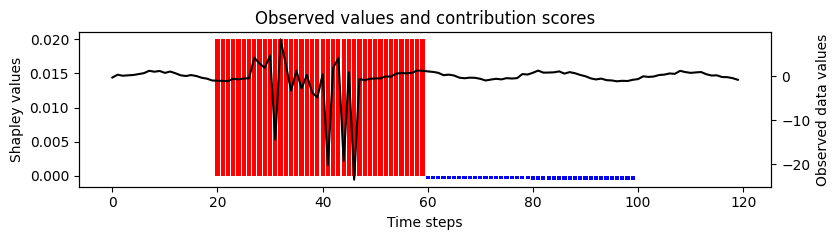

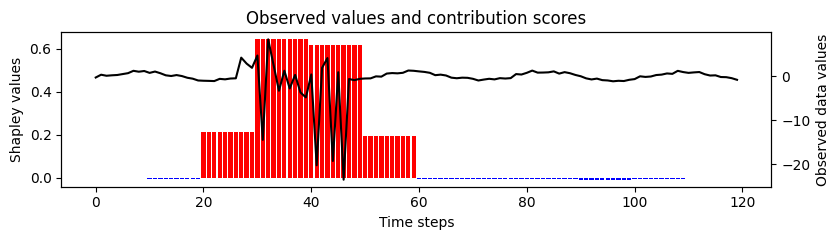

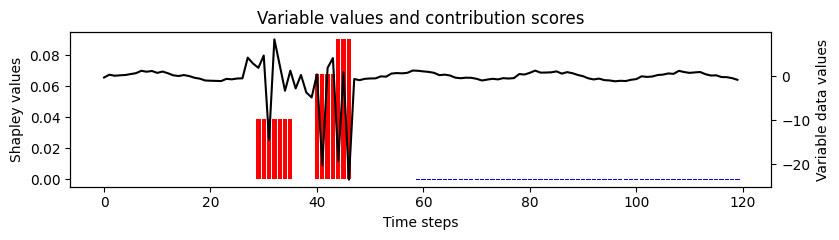

In [39]:
#from util import heat_map

var = 0
phi_index = 0
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var],
         shap_values=ts_phi_1[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var],
         shap_values=ts_phi_2[phi_index, :, var], var_name='Observed', plot_type='bar')
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var],
         shap_values=ts_phi_3[phi_index, :, var], var_name='Variable', plot_type='bar')